In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import optimize

%matplotlib inline

In [114]:
def V_morse(x):
    D = 0.1744 # 4.7457 eV
    beta = 1.02764 # 1.94196e10 m-1
    x_e = 1.40201 # 0.74191e-10 m

    return D*(1-np.exp(-beta*(x-x_e)))**2

def V_ho(x):
    return 0.5*x**2

def fgh(V, x_grid, m):
    
    N = x_grid.size
    delta_x = x_grid[1] - x_grid[0]
    xmax = x_grid[-1]

    H = np.zeros((N,N))

    T_k = np.zeros(N)
    for n in range(0,N):
        T_k[n] = 2/m * (np.pi*(n-(N-1)/2.0)/(xmax))**2
    T_k = np.fft.fftshift(T_k)

    for n in range(0,N):

        phi_n = np.zeros(N)
        phi_n[n] = 1

        V_phi_n = np.zeros(N)
        V_phi_n[n] = V(x_grid[n])

        # fast fourier transform
        F_phi_n = np.fft.fft(phi_n) # into k-space
        TF_phi_n = np.multiply(T_k, F_phi_n)
        T_phi_n = np.fft.ifft(TF_phi_n) # not sure if this is necessary

        H[:,n] = T_phi_n + V_phi_n

    # diagonalize
    E, psi = np.linalg.eig(H)
    E = np.real(E)

    # sort energies in increasing order
    ind = np.argsort(E)
    E = E[ind]
    psi = psi[:,ind]

    print(E[0:20])
    
    plt.plot(x_grid,psi[:,5])


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


[  0.20921676   0.37839991   0.46825468   0.97638314   1.07111552
   1.97177228   2.05203504   3.36050926   3.4259374    5.14227426
   5.19611604   7.31745776   7.36268821   9.88646002   9.92525524
  12.84957378  12.88345776  16.2069969   16.23704168  19.95886152]


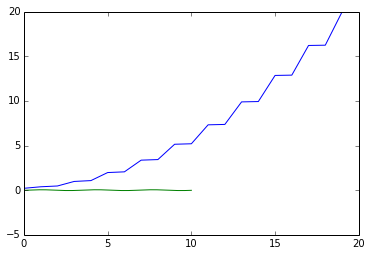

[ 0.00993532  0.02883393  0.04657987  0.06317313  0.07861371  0.09290161
  0.10603683  0.11801937  0.12884923  0.13852642  0.14705092  0.15442275
  0.16064189  0.16570836  0.16962215  0.17238327  0.17399917  0.17484764
  0.17587548  0.17720675]


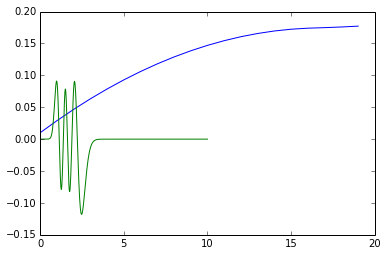

In [16]:
x_grid = np.linspace(0,10,1000)

#plt.plot(x_grid,V_morse(x_grid)/0.1744)
#plt.show()
fgh(V_morse,x_grid,1822/2.0)

In [115]:

def regrid(x_min, x_max, N, A, beta):
    
    x_mapping = lambda Q: x_min + Q - A * np.arctan(beta*Q)
        
    Q_max = sp.optimize.root(lambda Q: x_mapping(Q)-x_max,1.0).x
    Q_min = 0
    
    Q = np.linspace(Q_min, Q_max, N)
    #plt.plot(Q,x_mapping(Q))
    
    J = 1 - A * beta / (1 + (beta * Q)**2)
    
    return Q, J, x_mapping(Q)

def fgh_scaled(V, x_grid, x_coord, J, m):
    
    J_inv = J**(-1)
    
    N = x_grid.size
    delta_x = x_grid[1] - x_grid[0]
    xmax = x_grid[-1] - x_grid[0]

    H = np.zeros((N,N))

    T_k = np.zeros(N)
    for n in range(0,N):
        T_k[n] = n-(N-1)/2.0 # np.sqrt(2/m * (np.pi*(n-(N-1)/2.0)/(xmax))**2)
    T_k = np.fft.fftshift(T_k)

    for n in range(0,N):

        phi_n = np.zeros(N)
        phi_n[n] = 1

        V_phi_n = np.zeros(N)
        V_phi_n[n] = V(x_coord[n])

        # fast fourier transform
        F_phi_n = np.fft.fft(phi_n) # into k-space     
        
        dphi_dq = np.multiply(J_inv, np.fft.ifft(np.multiply(T_k, F_phi_n)))
        F_dphi_dq = np.fft.fft(dphi_dq)
        dphi_dq2 = np.multiply(J_inv, np.fft.ifft(np.multiply(T_k, F_dphi_dq)))
        T_phi_n = dphi_dq2 * 2/m * (np.pi/(xmax))**2

        H[:,n] = T_phi_n + V_phi_n

    # diagonalize
    E, psi = np.linalg.eig(H)
    E = np.real(E)

    # sort energies in increasing order
    ind = np.argsort(E)
    E = E[ind]
    psi = psi[:,ind]

    print(E[0:20])
    #plt.plot(E[0:20])
    
    plt.plot(x_coord,-psi[:,5])


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:47: ComplexWarning: Casting complex values to real discards the imaginary part


[ 0.0099899   0.02895615  0.04676084  0.06340394  0.07888545  0.09320536
  0.10636366  0.11836034  0.12919537  0.13886874  0.14738041  0.15473034
  0.16091845  0.16594463  0.16980869  0.17251019  0.17405927  0.17489706
  0.17595374  0.1773103 ]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


[ 0.00997307  0.02893971  0.04674483  0.0633884   0.07887044  0.09319094
  0.10634991  0.11834734  0.12918324  0.13885759  0.14737042  0.1547217
  0.16091146  0.16593967  0.16980635  0.1725115   0.17406612  0.17490659
  0.17596242  0.17731859]


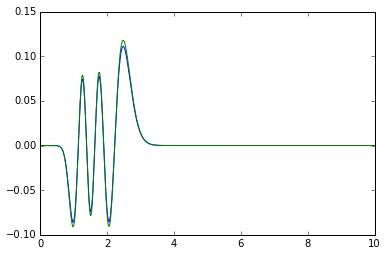

In [117]:
x_grid = np.linspace(0,10,1000)

Q_grid, J, x_coord = regrid(0,10,1000,9.9,0.05)

#fgh_scaled(V_morse,x_grid,x_grid,np.ones(x_grid.size),1822/2.0)
fgh_scaled(V_morse,Q_grid,x_coord,J,1822/2.0)
fgh(V_morse,x_grid,1822/2.0)

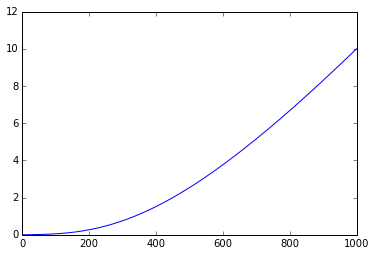

In [107]:
Q_grid, J, x_coord = regrid(0,10,1000,9.9,0.1) # A*beta < 1
plt.plot(x_coord)

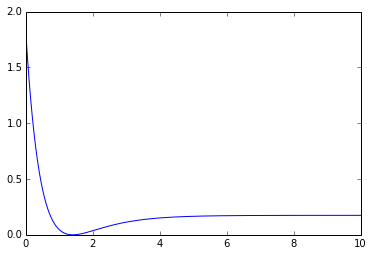

In [69]:
plt.plot(x_grid,V_morse(x_grid))